<a href="https://colab.research.google.com/github/hikaruy0804/DeepLearning/blob/main/2_1_%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%EF%BC%88%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF_CPU%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






**画像分類器の訓練**

2-1.深層学習（畳み込み-CPU）

以下の手順に従って実施します：

1. ``torchvision``でCIFAR10の訓練データとテストデータの読み込みと正規化
2. 畳み込みニューラルネットワークの定義
3. 損失関数の定義
4. 訓練データを用いたモデルの訓練
5. テストデータでモデルをテスト


[1] CIFAR10の読み込みと正規化
========

In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 画像の表示関数


def imshow(img):
    img = img / 2 + 0.5     # 正規化を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 適当な訓練セットの画像を取得
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

[2] 畳み込みニューラルネットワークの定義
=======


### 畳み込みニューラルネットワーク（Convolutional Neural Network、CNN）

畳み込みニューラルネットワーク（CNN）は画像認識タスクに用いられる深層学習モデルの一種です。

#### 畳み込み層
- **機能**: 画像の特徴を抽出します。
- **方法**: 畳み込み演算を行い、局所的な特徴を抽出します。フィルタと呼ばれる小さな重みを使用し、スライド窓を移動させながら画像の特徴を抽出します。

#### プーリング層
- **目的**: 畳み込み層によって得られた特徴マップを縮小するために使用します。
- **方法**: 通常、Maxプーリングと呼ばれる方法が使用され、各フィルターによって抽出された特徴マップ内の最大値を抽出します。
- **効果**: 画像の位置や方向に対するロバスト性が向上し、計算量も減少します。

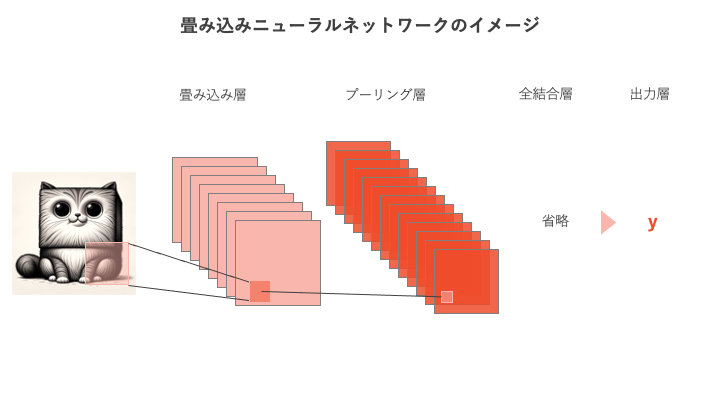

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #入力チャンネル、出力チャンネル、カーネルサイズ
        self.pool = nn.MaxPool2d(2, 2) #プーリングサイズ
        self.conv2 = nn.Conv2d(6, 16, 5) #入力チャンネル、出力チャンネル、カーネルサイズ
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


32x32ピクセルのRGB画像を入力として扱います。RGB画像は、赤・緑・青の3色のチャンネルを持っています。

### 最初の畳み込み層
- **入力**: 3チャンネルの画像（例：RGB色）
- **処理**: 6チャンネルの出力を生成します。この層のフィルタ（カーネル）サイズは5x5ピクセルです。これにより、32x32ピクセルの画像は、28x28ピクセルに小さくなります（余白を付けない場合）。

### 最初のプーリング層
- **処理**: 2x2ピクセルの範囲で最大値を選び出すことで、画像を小さくします。これにより、28x28ピクセルの画像は、14x14ピクセルに縮小されます。

### 次の畳み込み層
- **入力**: 6チャンネルの画像
- **処理**: 16チャンネルの出力を生成します。フィルタサイズは再び5x5ピクセルです。これにより、14x14ピクセルの画像は、10x10ピクセルに小さくなります。

### 2つ目のプーリング層
- **処理**: 同様に、2x2ピクセルの範囲で最大値を選び出し、画像をさらに小さくします。これにより、10x10ピクセルの画像は、5x5ピクセルに縮小されます。

16チャンネルの5x5ピクセルの特徴マップを持っています。これらを一列に並べる（フラット化する）と、合計400個の値（16チャンネル x 5 x 5）が得られ、これが次の全結合層への入力となります。

[3] 損失関数とオプティマイザの定義
=======


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

[4] ネットワークの訓練
=======
全結合層とlossの数値を比較してみましょう。

In [ ]:
for epoch in range(2):  # エポック数分ループを回します

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # データセットのデータを [inputs, labels]の形で取得
        inputs, labels = data

        # パラメータの勾配をリセット
        optimizer.zero_grad()

        # 順伝搬＋逆伝搬＋パラメータ更新
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 統計情報の表示
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2,000ミニバッチにつき1度表示
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

全結合層と比較して良い学習（lossが低く）ができています。

[5] テストデータでネットワークをテスト
============


In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 画像と正解ラベルの表示
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

では、テストデータセットの全体に対する予測精度を確認します。

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

最後にテストデータセットの各ラベルの予測精度を確認します。

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

# 演習
## コードを変更して精度の変化を確認しよう。

- 畳み込み層を変更する
- エポック（学習）数を増す
- 活性化関数を変更する
- オプティマイザを変更する
- 各パラメータを変更する

## 調べてみよう。
- 損失関数の種類を調べてみる。



---



# 引き続き

2-2.深層学習（畳み込み-GPU）.ipynb

でGPUでの実行試してみましょう。